In [19]:
!rm -rf cvae-quadratreeMRF # Remove old version if exists
!git clone https://github.com/realjules/cvae-quadratreeMRF.git
import sys
sys.path.append('/kaggle/working/cvae-quadratreeMRF')

Cloning into 'cvae-quadratreeMRF'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 43 (delta 8), reused 36 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 2.07 MiB | 28.30 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [21]:
# Import required libraries
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.morphology import disk
from glob import glob
import random
import os
from tqdm.notebook import tqdm
import cv2

# Import project modules
from dataset.dataset import ISPRS_dataset
from net.net import CRFNet
from net.loss import CrossEntropy2d
from utils.utils_dataset import convert_to_color, convert_from_color
from utils.utils_network import compute_class_weight
from utils.utils import accuracy

In [23]:
# Configuration Cell - For reproducing the CRFNet-RS paper results
# ---------------------------------------------------

# Base parameters from the paper
WINDOW_SIZE = (256, 256)  # Patch size specified in the paper
STRIDE = 32  # Stride for testing specified in the paper
BATCH_SIZE = 10  # Number of samples in a mini-batch specified in the paper
base_lr = 0.01  # Base learning rate specified in the paper
WEIGHT_DECAY = 0.0005  # Weight decay specified in the paper
EPOCHS = 30  # Number of epochs specified in the paper

# Other necessary parameters
IN_CHANNELS = 3  # IRRG channels as mentioned in the paper
SAVE_EPOCH = 5  # Save model every N epochs
OUTPUT_FOLDER = "./output"  # Output directory
CACHE = True  # Store dataset in memory
DISPLAY_ITER = 100  # Display interval

# Create output directory
import os
import torch
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Ground truth configuration - this can be changed to reproduce different conditions from the paper
# Options: 'full', 'conncomp' (for the 30% or 10% scarce GT)
GT_TYPE = 'full'  # Change to 'conncomp' for reproducing scarce GT experiments
SCARCITY_LEVEL = 30  # Either 30% or 10% for scarce GT - only applies when GT_TYPE is 'conncomp'

# Class definitions (same for both datasets)
LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"]
N_CLASSES = len(LABELS)

# Dataset selection - Choose which dataset(s) to use as per the paper
USE_VAIHINGEN = True  # Set to True to use Vaihingen dataset
USE_POTSDAM = False   # Set to True to use Potsdam dataset

# ===== Vaihingen Dataset Configuration =====
FOLDER = "/kaggle/input/potsdamvaihingen/"
VAIHINGEN_FOLDER = FOLDER + "ISPRS_semantic_labeling_Vaihingen/"
VAIHINGEN_DATA_FOLDER = VAIHINGEN_FOLDER + "top/top_mosaic_09cm_area{}.tif"
VAIHINGEN_LABEL_FOLDER = VAIHINGEN_FOLDER + "gts_for_participants/top_mosaic_09cm_area{}.tif"

# Vaihingen train/test split as specified in the paper
VAIHINGEN_TRAIN_IDS = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
VAIHINGEN_TEST_IDS = ['5', '15', '21', '30']  # Corrected: '15' instead of previously used value

# ===== Potsdam Dataset Configuration =====
POTSDAM_FOLDER = FOLDER
POTSDAM_DATA_FOLDER = POTSDAM_FOLDER + "3_Ortho_IRRG/3_Ortho_IRRG/top_potsdam_{}_{}_IRRG.tif"
POTSDAM_LABEL_FOLDER = POTSDAM_FOLDER + "5_Labels_for_participants/5_Labels_for_participants/top_potsdam_{}_{}_label.tif"

# Potsdam train/test split as specified in the paper
POTSDAM_TRAIN_TILES = ['3_11', '4_11', '5_10', '6_7', '6_8', '6_9', '7_7', '7_8', '7_9', '7_10']
POTSDAM_TEST_TILES = ['3_12', '4_10', '4_12', '5_11', '6_12']

# Experiment name (useful for organizing output files)
if USE_VAIHINGEN and USE_POTSDAM:
    DATASET_NAME = "combined"
elif USE_VAIHINGEN:
    DATASET_NAME = "vaihingen"
else:
    DATASET_NAME = "potsdam"
    
EXP_NAME = f"{DATASET_NAME}_{GT_TYPE}"
if GT_TYPE == 'conncomp':
    EXP_NAME += f"_{SCARCITY_LEVEL}percent"

# Create specific output folder for this experiment
EXP_OUTPUT_FOLDER = os.path.join(OUTPUT_FOLDER, EXP_NAME)
os.makedirs(EXP_OUTPUT_FOLDER, exist_ok=True)

# For erosion in case of conncomp GT
from skimage.morphology import disk
ERO_DISK_SIZE = 3  # Size of the morphological disk for erosion

# Optimization parameters
MOMENTUM = 0.9
LR_STEPS = [25, 35, 45]  # Steps for learning rate decay
LR_GAMMA = 0.1  # Gamma factor for learning rate decay
BILINEAR = True  # Whether to use bilinear upsampling in the model

# Initialize weights for class balancing
WEIGHTS = torch.ones(N_CLASSES)

# Set the train/test IDs based on dataset selection
train_ids = []
test_ids = []

if USE_VAIHINGEN:
    train_ids.extend(VAIHINGEN_TRAIN_IDS if not USE_POTSDAM else [f"v_{id}" for id in VAIHINGEN_TRAIN_IDS])
    test_ids.extend(VAIHINGEN_TEST_IDS if not USE_POTSDAM else [f"v_{id}" for id in VAIHINGEN_TEST_IDS])

if USE_POTSDAM:
    train_ids.extend(POTSDAM_TRAIN_TILES if not USE_VAIHINGEN else [f"p_{id}" for id in POTSDAM_TRAIN_TILES])
    test_ids.extend(POTSDAM_TEST_TILES if not USE_VAIHINGEN else [f"p_{id}" for id in POTSDAM_TEST_TILES])

print(f"Experiment: {EXP_NAME}")
print(f"Configuration loaded! Using {'scarce' if GT_TYPE == 'conncomp' else 'full'} ground truth" + 
      (f" at {SCARCITY_LEVEL}% level" if GT_TYPE == 'conncomp' else ""))

Experiment: vaihingen_full
Configuration loaded! Using full ground truth


In [24]:
# Function to get file paths based on dataset ID
def get_data_path(id):
    if id.startswith("v_"):
        # Vaihingen dataset
        real_id = id[2:]  # Remove the v_ prefix
        return VAIHINGEN_DATA_FOLDER.format(real_id)
    else:
        # Potsdam dataset - the ID format is like "p_2_10"
        if id.startswith("p_"):
            id = id[2:]  # Remove the p_ prefix
        # Split the ID into row and column
        row, col = id.split("_")
        return POTSDAM_DATA_FOLDER.format(row, col)

# Function to get label paths based on dataset ID
def get_label_path(id):
    if id.startswith("v_"):
        # Vaihingen dataset
        real_id = id[2:]  # Remove the v_ prefix
        return VAIHINGEN_LABEL_FOLDER.format(real_id)
    else:
        # Potsdam dataset
        if id.startswith("p_"):
            id = id[2:]  # Remove the p_ prefix
        # Split the ID into row and column
        row, col = id.split("_")
        return POTSDAM_LABEL_FOLDER.format(row, col)

print("Tiles for training:", train_ids)
print("Tiles for testing:", test_ids)

# Define the ground truth modification function based on configuration
if GT_TYPE == 'conncomp':
    try:
        # Import the conn_comp function
        from utils.utils_dataset import conn_comp
        
        # For scarce GT, use connected components to reduce the ground truth
        def gt_modification_func(gt_image):
            # Apply connected component analysis to reduce GT to specified percentage
            return conn_comp(gt_image, disk(ERO_DISK_SIZE), target_percentage=SCARCITY_LEVEL/100)
        
        # Create a visualization of the scarce GT for the first training image
        if train_ids:
            # Get the first training ID
            first_id = train_ids[0]
            if first_id.startswith("v_") or first_id.startswith("p_"):
                label_path = get_label_path(first_id)
            elif USE_VAIHINGEN:
                label_path = VAIHINGEN_LABEL_FOLDER.format(first_id)
            else:
                row, col = first_id.split("_")
                label_path = POTSDAM_LABEL_FOLDER.format(row, col)
            
            try:
                # Load the first training image GT
                label_img = io.imread(label_path)
                
                # Apply the conn_comp function
                scarce_gt = conn_comp(label_img, disk(ERO_DISK_SIZE), target_percentage=SCARCITY_LEVEL/100)
                
                # Visualize original vs scarce GT
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
                ax1.imshow(convert_to_color(label_img))
                ax1.set_title("Original Ground Truth")
                ax2.imshow(convert_to_color(scarce_gt))
                ax2.set_title(f"Scarce Ground Truth ({SCARCITY_LEVEL}%)")
                plt.tight_layout()
                plt.show()
                
                # Calculate actual percentage of remaining labels
                total_pixels = label_img.size
                remaining_pixels = np.count_nonzero(scarce_gt)
                actual_percentage = (remaining_pixels / total_pixels) * 100
                print(f"Target percentage: {SCARCITY_LEVEL}%, Actual percentage: {actual_percentage:.2f}%")
            except Exception as e:
                print(f"Could not visualize scarce GT: {e}")
    except ImportError:
        print("Warning: conn_comp function not found in utils.utils_dataset. Using erosion disk for GT modification.")
        gt_modification_func = disk(ERO_DISK_SIZE)
else:
    # For full GT, use standard erosion disk
    gt_modification_func = disk(ERO_DISK_SIZE)

# Initialize datasets based on configuration
if USE_VAIHINGEN and USE_POTSDAM:
    # Create a custom dataset class for the combined dataset
    class CombinedDataset(ISPRS_dataset):
        def get_data_path(self, id):
            return get_data_path(id)
        
        def get_label_path(self, id):
            return get_label_path(id)
    
    # Initialize datasets using the combined dataset class
    train_set = CombinedDataset(
        ids=train_ids,
        ids_type='TRAIN',
        gt_type=GT_TYPE,
        gt_modification=gt_modification_func,
        window_size=WINDOW_SIZE,
        cache=CACHE,
        augmentation=True
    )
    
    test_set = CombinedDataset(
        ids=test_ids,
        ids_type='TEST',
        gt_type='full',  # Always use full GT for testing
        gt_modification=disk(ERO_DISK_SIZE),
        window_size=WINDOW_SIZE,
        cache=CACHE,
        augmentation=False
    )
elif USE_VAIHINGEN:
    # Initialize datasets using just Vaihingen
    train_set = ISPRS_dataset(
        ids=train_ids,
        ids_type='TRAIN',
        gt_type=GT_TYPE,
        gt_modification=gt_modification_func,
        data_files=VAIHINGEN_DATA_FOLDER,
        label_files=VAIHINGEN_LABEL_FOLDER,
        window_size=WINDOW_SIZE,
        cache=CACHE,
        augmentation=True
    )
    
    test_set = ISPRS_dataset(
        ids=test_ids,
        ids_type='TEST',
        gt_type='full',  # Always use full GT for testing
        gt_modification=disk(ERO_DISK_SIZE),
        data_files=VAIHINGEN_DATA_FOLDER,
        label_files=VAIHINGEN_LABEL_FOLDER,
        window_size=WINDOW_SIZE,
        cache=CACHE,
        augmentation=False
    )
elif USE_POTSDAM:
    # Initialize datasets using just Potsdam
    # Need a custom class to handle the different path format
    class PotsdamDataset(ISPRS_dataset):
        def get_data_path(self, id):
            # Split the ID into row and column
            row, col = id.split("_")
            return self.data_files.format(row, col)
        
        def get_label_path(self, id):
            # Split the ID into row and column
            row, col = id.split("_")
            return self.label_files.format(row, col)
    
    train_set = PotsdamDataset(
        ids=train_ids,
        ids_type='TRAIN',
        gt_type=GT_TYPE,
        gt_modification=gt_modification_func,
        data_files=POTSDAM_DATA_FOLDER,
        label_files=POTSDAM_LABEL_FOLDER,
        window_size=WINDOW_SIZE,
        cache=CACHE,
        augmentation=True
    )
    
    test_set = PotsdamDataset(
        ids=test_ids,
        ids_type='TEST',
        gt_type='full',  # Always use full GT for testing
        gt_modification=disk(ERO_DISK_SIZE),
        data_files=POTSDAM_DATA_FOLDER,
        label_files=POTSDAM_LABEL_FOLDER,
        window_size=WINDOW_SIZE,
        cache=CACHE,
        augmentation=False
    )

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

# Initialize the model according to original implementation
net = CRFNet(n_channels=IN_CHANNELS, n_classes=N_CLASSES, bilinear=BILINEAR)

# Move model to GPU if available
if torch.cuda.is_available():
    net.cuda()
    WEIGHTS = WEIGHTS.cuda()

# Set up optimizer with different learning rates for encoder and decoder
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params': [value], 'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2
        params += [{'params': [value], 'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, LR_STEPS, gamma=LR_GAMMA)

print(f"Setup complete! Ready to train model for {EXP_NAME}")

Tiles for training: ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
Tiles for testing: ['5', '15', '21', '30']
Setup complete! Ready to train model for vaihingen_full


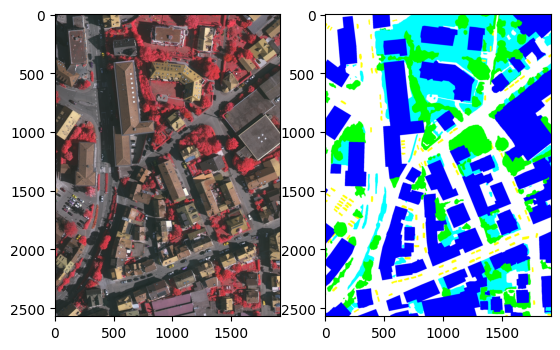

In [25]:
# # Parameters
# WINDOW_SIZE = (256, 256) # Patch size
# STRIDE = 32 # Stride for testing
# IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
# FOLDER = "../input/potsdamvaihingen/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
# BATCH_SIZE = 10 # Number of samples in a mini-batch

# LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
# N_CLASSES = len(LABELS) # Number of classes
# WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
# CACHE = True # Store the dataset in-memory

# DATASET = 'Vaihingen'
# MAIN_FOLDER = FOLDER + 'ISPRS_semantic_labeling_Vaihingen/'
# DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
# LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'

# # ISPRS color palette
# # Let's define the standard ISPRS color palette
# palette = {0 : (255, 255, 255), # Impervious surfaces (white)
#            1 : (0, 0, 255),     # Buildings (blue)
#            2 : (0, 255, 255),   # Low vegetation (cyan)
#            3 : (0, 255, 0),     # Trees (green)
#            4 : (255, 255, 0),   # Cars (yellow)
#            5 : (255, 0, 0),     # Clutter (red)
#            6 : (0, 0, 0)}       # Undefined (black)

# invert_palette = {v: k for k, v in palette.items()}

# We load one tile from the dataset and we display it
img = io.imread('../input/potsdamvaihingen/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area1.tif')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread('../input/potsdamvaihingen/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area1.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

In [29]:
# Training Function Cell
def train_model():
    # Arrays to store losses and metrics
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    all_epoch_losses = []  # Track average loss per epoch
    all_epoch_accuracies = []  # Track test accuracy per epoch
    best_accuracy = 0.0  # Track best test accuracy
    
    iter_ = 0
    
    # Create a file to log metrics
    log_file = os.path.join(EXP_OUTPUT_FOLDER, "training_log.csv")
    with open(log_file, 'w') as f:
        f.write("Epoch,Train_Loss,Train_Accuracy,Test_Accuracy\n")

    for e in tqdm(range(1, EPOCHS + 1)):
        net.train()
        epoch_losses = []  # Track losses for this epoch
        epoch_train_accuracies = []  # Track training accuracies
        
        # Training loop
        for batch_idx, (data, target) in enumerate(train_loader):
            # Process target for multi-scale supervision
            target = target.data.cpu().numpy()
            target = np.transpose(target, [1, 2, 0])
            target3 = np.transpose(cv2.resize(target, dsize=(128, 128), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
            target2 = np.transpose(cv2.resize(target, dsize=(64, 64), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
            target1 = np.transpose(cv2.resize(target, dsize=(32, 32), interpolation=cv2.INTER_NEAREST), [2, 0, 1])
            target = np.transpose(target, [2, 0, 1])

            # Move data to GPU
            data, target = data.cuda(), torch.from_numpy(target).cuda()

            optimizer.zero_grad()

            # Forward pass
            output, out_fc, out_neigh, _ = net(data)

            # Calculate losses at different scales
            loss = CrossEntropy2d(output, target, weight=WEIGHTS)
            loss_fc1 = CrossEntropy2d(
                out_fc[0],
                torch.from_numpy(target1).type(torch.LongTensor).cuda(),
                weight=compute_class_weight(target1).cuda()
            )
            loss_fc2 = CrossEntropy2d(
                out_fc[1],
                torch.from_numpy(target2).type(torch.LongTensor).cuda(),
                weight=compute_class_weight(target2).cuda()
            )
            loss_fc3 = CrossEntropy2d(
                out_fc[2],
                torch.from_numpy(target3).type(torch.LongTensor).cuda(),
                weight=compute_class_weight(target3).cuda()
            )

            # Pairwise loss for neighborhood consistency
            pairwise_loss = CrossEntropy2d(out_neigh, target, weight=WEIGHTS)

            # Combine all losses
            total_loss = (loss + loss_fc1 + loss_fc2 + loss_fc3) / 4 + pairwise_loss

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            # Record loss
            loss_value = total_loss.item()
            epoch_losses.append(loss_value)
            losses[iter_] = loss_value
            mean_losses[iter_] = np.mean(losses[max(0, iter_-100):iter_])
            
            # Calculate and record training accuracy
            with torch.no_grad():
                pred = np.argmax(output.detach().cpu().numpy()[0], axis=0)
                gt = target.cpu().numpy()[0]
                batch_accuracy = accuracy(pred, gt)
                if not np.isnan(batch_accuracy):
                    epoch_train_accuracies.append(batch_accuracy)
            
            # Print occasional progress without images
            if iter_ % DISPLAY_ITER == 0:
                print(f'Train (epoch {e}/{EPOCHS}) [{batch_idx}/{len(train_loader)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss_value:.6f}')
            
            iter_ += 1
        
        # End of epoch - calculate average metrics
        avg_epoch_loss = np.mean(epoch_losses)
        avg_train_accuracy = np.mean(epoch_train_accuracies) if epoch_train_accuracies else 0.0
        all_epoch_losses.append(avg_epoch_loss)
        
        # Run validation on test set
        test_accuracies = evaluate_model(verbose=False)
        avg_test_accuracy = np.mean(test_accuracies)
        all_epoch_accuracies.append(avg_test_accuracy)
        
        # Log metrics to file
        with open(log_file, 'a') as f:
            f.write(f"{e},{avg_epoch_loss:.6f},{avg_train_accuracy:.2f},{avg_test_accuracy:.2f}\n")
        
        # Save best model
        if avg_test_accuracy > best_accuracy:
            best_accuracy = avg_test_accuracy
            torch.save(net.state_dict(), os.path.join(EXP_OUTPUT_FOLDER, "model_best.pth"))
            print(f"New best model saved! Test accuracy: {best_accuracy:.2f}%")
            
        # Visualize results at the end of each epoch
        print(f'Epoch {e}/{EPOCHS} completed.')
        print(f'Average Training Loss: {avg_epoch_loss:.6f}')
        print(f'Average Training Accuracy: {avg_train_accuracy:.2f}%')
        print(f'Average Test Accuracy: {avg_test_accuracy:.2f}%')
        
        # Plot training progress
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(all_epoch_losses)
        ax1.set_title(f'Training Loss (Current: {avg_epoch_loss:.4f})')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        # Plot test accuracy
        ax2.plot(all_epoch_accuracies)
        ax2.set_title(f'Test Accuracy (Current: {avg_test_accuracy:.2f}%)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(EXP_OUTPUT_FOLDER, f"training_progress_epoch{e}.png"))
        plt.show()

        # Update learning rate scheduler
        scheduler.step()

        # Save model checkpoint
        if e % SAVE_EPOCH == 0 or e == EPOCHS:
            torch.save(net.state_dict(), os.path.join(EXP_OUTPUT_FOLDER, f"model_epoch{e}.pth"))
            print(f"Checkpoint saved at epoch {e}")

    # Save final model
    torch.save(net.state_dict(), os.path.join(EXP_OUTPUT_FOLDER, "model_final.pth"))
    print("Training completed!")
    print(f"Best test accuracy: {best_accuracy:.2f}%")
    
    # Final evaluation with detailed metrics
    evaluate_model(verbose=True)
    
    return all_epoch_losses, all_epoch_accuracies, best_accuracy

In [30]:
def evaluate_model(verbose=True):
    """Evaluate the model on the test set and calculate metrics"""
    net.eval()
    test_accuracies = []
    class_accuracies = np.zeros(N_CLASSES)
    class_counts = np.zeros(N_CLASSES)
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # Move data to GPU
            data = data.cuda()
            
            # Forward pass
            output, _, _, _ = net(data)
            
            # Convert to numpy for evaluation
            pred = output.cpu().numpy()
            target = target.cpu().numpy()
            
            # Process each image in the batch
            for i in range(pred.shape[0]):
                p = np.argmax(pred[i], axis=0)
                t = target[i].squeeze()
                
                # Calculate overall accuracy
                batch_accuracy = accuracy(p, t)
                if not np.isnan(batch_accuracy):
                    test_accuracies.append(batch_accuracy)
                
                # Store predictions and targets for confusion matrix
                all_predictions.append(p.flatten())
                all_targets.append(t.flatten())
                
                # Calculate per-class accuracies
                for cls in range(N_CLASSES):
                    mask = (t == cls)
                    if np.any(mask):
                        class_counts[cls] += np.sum(mask)
                        class_accuracies[cls] += np.sum((p == cls) & mask)
    
    # Calculate metrics
    class_accuracies = np.divide(class_accuracies, class_counts, out=np.zeros_like(class_accuracies), where=class_counts!=0) * 100
    mean_accuracy = np.mean(test_accuracies)
    
    if verbose:
        print("\n===== Model Evaluation =====")
        print(f"Overall Accuracy: {mean_accuracy:.2f}%")
        print("\nPer-class Accuracies:")
        for cls in range(N_CLASSES):
            print(f"  {LABELS[cls]}: {class_accuracies[cls]:.2f}%")
        
        # If possible, create confusion matrix
        try:
            from sklearn.metrics import confusion_matrix
            import seaborn as sns
            
            # Flatten and concatenate all predictions and targets
            all_preds_flat = np.concatenate(all_predictions)
            all_targets_flat = np.concatenate(all_targets)
            
            # Calculate confusion matrix
            cm = confusion_matrix(all_targets_flat, all_preds_flat, labels=range(N_CLASSES))
            
            # Normalize by row (true labels)
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            
            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues', 
                       xticklabels=LABELS, yticklabels=LABELS)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix ({EXP_NAME})')
            plt.savefig(os.path.join(EXP_OUTPUT_FOLDER, "confusion_matrix.png"))
            plt.show()
        except Exception as e:
            print(f"Could not create confusion matrix: {e}")
    
    # Return accuracies for tracking
    return test_accuracies

In [ ]:
# Execute this line to start training
train_model()

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Train (epoch 1/30) [0/1000 (0%)]	Loss: 2.035622
